In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

In [110]:
# Sample of apartment prices of 2020 from Ciudad Autonoma de Buenos Aires
apt_prices_caba = pd.read_csv('data/departamentos-en-venta-2020.csv')

loans_income = pd.read_csv('data/loans_income.csv')

## Sampling Distribution of a Statistic

- The frequency distribution of a **sample statistic** tells us how that metric would turn out differently from sample to sample.
- This sampling distribution can be estimated via the **bootstrap**, or via formulas that rely on the central limit theorem.
- A key metric that sums up the variability of a sample statistic is its **standard error**.

In [3]:
sample_data = pd.DataFrame({ # Sample of 2000 apartment prices
    'price': apt_prices_caba['Dolares'].sample(2000),
    'type': 'Data'
})
sample_mean_5 = pd.DataFrame({ # Sample of 2000 means of 5 prices
    'price': [apt_prices_caba['Dolares'].sample(5).mean() for _ in range(2000)],
    'type': 'Mean of 5'
})
sample_mean_20 = pd.DataFrame({ # Sample of 2000 means of 20 prices
    'price': [apt_prices_caba['Dolares'].sample(20).mean() for _ in range(2000)],
    'type': 'Mean of 20'
})
sample_mean_50 = pd.DataFrame({ # Sample of 2000 means of 50 prices
    'price': [apt_prices_caba['Dolares'].sample(50).mean() for _ in range(2000)],
    'type': 'Mean of 50'
})

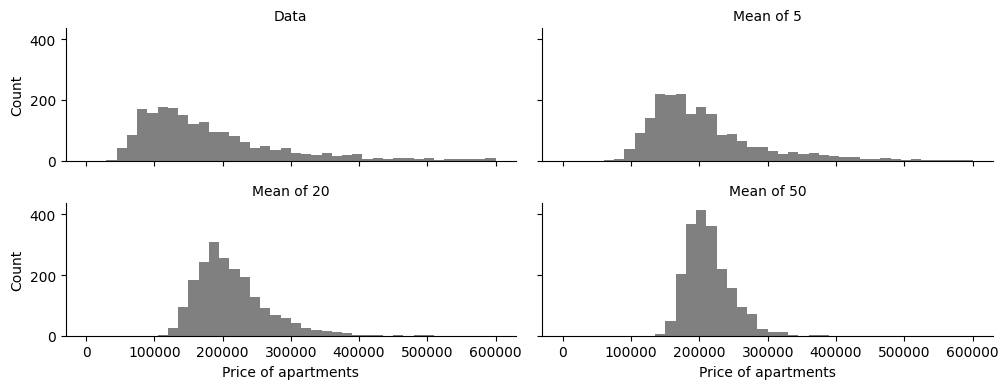

In [4]:
results = pd.concat([sample_data, sample_mean_5, sample_mean_20, sample_mean_50])
g = sns.FacetGrid(results, col='type', col_wrap=2, height=2, aspect=2.5)
g.map(plt.hist, 'price', range=[0, 6e5], bins=40, color='grey')
g.set_axis_labels('Price of apartments', 'Count')
g.set_titles('{col_name}')

The histogram of the individual data values is broadly spread out and skewed toward higher prices (outliers), as is to be expected with income data. The histograms of the means of 5, 20 and 50 are increasingly compact and more normal-shaped.  

### Why?
The distribution of a **sample statistic such as the mean** is likely to be more **regular and bell-shaped** than the distribution of the data itself. The larger the sample the statistic is based on, the more this is true. Also, the larger the sample, the narrower the distribution of the sample statistic.  

The science behind it is the **Central Limit Theorem**: the means drawn from multiple samples will resemble the familiar bell-shaped normal curve — even if the source population is not normally distributed.

In [5]:
# Compute standars deviations
sample_data_std = sample_data['price'].std()
sample_mean_5_std = sample_mean_5['price'].std()
sample_mean_20_std = sample_mean_20['price'].std()
sample_mean_50_std = sample_mean_50['price'].std()

# Compute standard errors
se_data = sample_data_std / np.sqrt(2000)
se_mean_5 = sample_mean_5_std / np.sqrt(2000)
se_mean_20 = sample_mean_20_std / np.sqrt(2000)
se_mean_50 = sample_mean_50_std / np.sqrt(2000)

print("Standard Errors:")
print("Sample Data:", se_data)
print("Sample Mean of 5:", se_mean_5)
print("Sample Mean of 20:", se_mean_20)
print("Sample Mean of 50:", se_mean_50)

Standard Errors:
Sample Data: 4275.001793033262
Sample Mean of 5: 2416.247580828819
Sample Mean of 20: 1148.7643713146404
Sample Mean of 50: 732.8805406080509


## Bootstrapping

- The bootstrap (sampling with replacement from a data set) is a powerful tool for assessing the variability of a sample statistic.
- The bootstrap can be applied in similar fashion in a wide variety of circumstances, without extensive study of mathematical approximations to sampling distributions.
- It also allows us to estimate sampling distributions for statistics where no mathematical approximation has been developed, nor no mathematical information about the population is given.
- When applied to predictive models, aggregating multiple bootstrap sample predictions (bagging) outperforms the use of a single model.


In [141]:
# Take the sample of the apartments, specifically the m^2 prices
apt_m2_prices = apt_prices_caba['DolaresM2']

bootstrap_results = []
for _ in range(1000):
    new_sample = resample(apt_m2_prices)
    bootstrap_results.append(new_sample.median())

bootstrap_results = pd.Series(bootstrap_results)
print('Bootstrap Statistics:')
print(f'Original median: {apt_m2_prices.median()}')
print(f'Bias: {round(bootstrap_results.mean() - apt_m2_prices.median(), 4)}')
print(f'Std. error: {round(bootstrap_results.std(), 4)}')

Bootstrap Statistics:
Original median: 2757.0
Bias: -0.134
Std. error: 2.9939


The bootstrap does not compensate for a small sample size; it does not create new data, nor does it fill in holes in an existing data set. It merely informs us about how lots of additional samples would behave when drawn from a population like our original sample.